In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [67]:
df = pd.read_csv('./../../datasets/chattahoochee-columbus.csv',header=0, parse_dates=['time'])

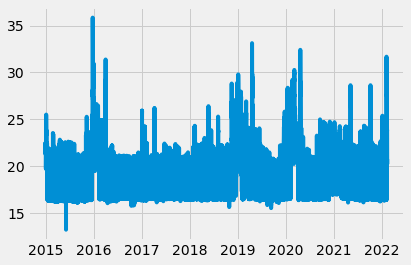

In [3]:
df["time"] = pd.to_datetime(df['time'])
df = df.set_index('time')
plt.plot(df.index,df["height"])

In [4]:
train_set = df[:'2020'].iloc[:,:]
test_set = df['2021':].iloc[:,:]

In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(train_set)

In [6]:
len(training_set_scaled)

210350

In [7]:
X_train = []
y_train = []
for i in range(100,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-100:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [9]:
X_train.shape

(210250, 100, 1)

In [10]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=8)

In [12]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [13]:
def Wape(y, y_pred):
    """Weighted Average Percentage Error metric in the interval [0; 100]"""
    nominator = tf.reduce_sum(tf.abs(tf.subtract(y, y_pred)))
    denominator = tf.add(tf.reduce_sum(tf.abs(y)), K.epsilon())
    wape = tf.scalar_mul(100.0, tf.divide(nominator, denominator))
    return wape

# Load Model

In [14]:
from tensorflow import keras
LSTM = keras.models.load_model('Columbus-LSTM.h5',custom_objects={"Wape": Wape})

CNN = keras.models.load_model('Columbus-CNN.h5',custom_objects={"Wape": Wape})

Dense = keras.models.load_model('Columbus-50Epoch-Dense.h5',custom_objects={"Wape": Wape})

2022-04-13 09:23:01.780658: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [47]:
train_set = df[:'2020'].iloc[:,:]
test_set = df['2022-02-07 05':].iloc[:,:]

In [16]:
train_set = df[:].iloc[:,:]
test_set = df[100:].iloc[:,:]

In [48]:
inputs = df[len(df) - len(test_set) - 100:].values
#df[len(df) - len(test_set) - 100:]

In [18]:
from itertools import chain
#flatten_list = list(chain.from_iterable(Denseprediction.tolist()))

Test_df = df[100:].iloc[:,:]

In [49]:
inputs = sc.fit_transform(inputs)
# inputs

In [50]:
# Preparing X_test and predicting the prices 
from numpy import savetxt

X_test = []
for i in range(100,len(inputs)):
    X_test.append(inputs[i-100:i,0])
X_test = np.array(X_test)
#savetxt('data.csv', X_test, delimiter=',')
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
LSTMprediction = LSTM.predict(X_test)
LSTMprediction = sc.inverse_transform(LSTMprediction)

(241, 100, 1)


In [51]:
# Preparing X_test and predicting the prices 
from numpy import savetxt

X_test = []
for i in range(100,len(inputs)):
    X_test.append(inputs[i-100:i,0])
X_test = np.array(X_test)
#savetxt('data.csv', X_test, delimiter=',')
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
CNNprediction = CNN.predict(X_test)
CNNprediction = sc.inverse_transform(CNNprediction)

In [52]:
# Preparing X_test and predicting the prices 
from numpy import savetxt

X_test = []
for i in range(100,len(inputs)):
    X_test.append(inputs[i-100:i,0])
X_test = np.array(X_test)
#savetxt('data.csv', X_test, delimiter=',')
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
Denseprediction = Dense.predict(X_test)
Denseprediction = sc.inverse_transform(Denseprediction)

In [24]:
# Evaluating our model
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from math import sqrt
import tensorflow.keras.backend as K
import hydroeval as he


def wape(y, y_pred):
    """Weighted Average Percentage Error metric in the interval [0; 100]"""
    nominator = tf.reduce_sum(tf.abs(tf.subtract(y, y_pred)))
    denominator = tf.add(tf.reduce_sum(tf.abs(y)), K.epsilon())
    wape = tf.scalar_mul(100.0, tf.divide(nominator, denominator))
    return wape

def Performance(test,Dense,CNN,LSTM):
    #print("Nash-Sutcliffe Efficiency:",nse)
    print("Dense")
    print("MSE:",MSE(test,Dense))
    print("MAE:",MAE(test,Dense))
    rmse = sqrt(MSE(test, Dense))
    print("RMSE:",rmse)
    print("MAPE:",MAPE(test,Dense))
    nse = he.evaluator(he.nse, Dense, test)
    print("NSE:",nse)
    print("WAPE:",wape(test,Dense))

    print("\n\nCNN")
    print("MSE:",MSE(test,CNN))
    print("MAE:",MAE(test,CNN))
    rmse = sqrt(MSE(test, CNN))
    print("RMSE:",rmse)
    nse = he.evaluator(he.nse, CNN, test)
    print("NSE:",nse)
    print("MAPE:",MAPE(test,CNN))
    print("WAPE:",wape(test,CNN))
    
    
    print("\n\nLSTM")
    print("MSE:",MSE(test,LSTM))
    print("MAE:",MAE(test,LSTM))
    rmse = sqrt(MSE(test, LSTM))
    print("RMSE:",rmse)
    nse = he.evaluator(he.nse, LSTM, test)
    print("NSE:",nse)
    print("MAPE:",MAPE(test,LSTM))
    print("WAPE:",wape(test,LSTM))


## 60 Hrs

In [33]:
from itertools import chain
#flatten_list = list(chain.from_iterable(Denseprediction.tolist()))

Test_df = df[100:]
len(Test_df)

249088

In [34]:
import math
from sklearn.metrics import mean_squared_error
from matplotlib.axes import Axes as ax
import datetime
# Some functions to help out with
from matplotlib.pyplot import figure
def plot_predictions(test,LSTMpredicted, CNN, Dense):
    fig, ax = plt.subplots(figsize=(20,30), tight_layout=True)
    plt.xticks(rotation=45)
    ax.plot(Test_df[:].index, test,color='black',label='Obsevervation',marker='s')
    ax.plot(Test_df[:].index, LSTMpredicted,color='red',label='LSTM Prediction',linewidth=4,marker='o')
    ax.plot(Test_df[:].index, Dense, color='plum',label='Dense Prediction',marker='D', linestyle=":")
    ax.plot(Test_df[:].index, CNN, color='burlywood',label='CNN Prediction',marker='o',linestyle="-.")
    #ax.plot(df[len(df) - len(test_set) - 100:][90:101].index, df[len(df) - len(test_set) - 101:][90:101].values,color='dimgrey',label='Random Data input',marker='s')
    plt.xlabel('Date',{'fontname':'monospace'})
    plt.ylabel('Gage height (ft)')
    plt.legend()
    
    # inset axes....
    axins = ax.inset_axes([0.21, 0.87, 0.7, 0.15])
    axins.plot(Test_df[:].index, test[:],color='black',label='Obsevervation',marker='s')
    axins.plot(Test_df[:].index, LSTMpredicted,color='red',label='LSTM Prediction',linewidth=4,marker='o')
    axins.plot(Test_df[:].index, Dense, color='plum',label='Dense Prediction',marker='D', linestyle=":")
    axins.plot(Test_df[:].index, CNN, color='burlywood',label='CNN Prediction',marker='o',linestyle="-.")
    #axins.plot(df[len(df) - len(test_set) - 100:][90:101].index, df[len(df) - len(test_set) - 101:][90:101].values,color='dimgrey',label='Random Data input',marker='s')
    axins.grid(False)
    # sub region of the original image
    x1, x2, y1, y2 = Test_df[:].index[80000],Test_df[:].index[130000], 15, 27

    axins.set_xlim(x1, x2)
    axins.set_ylim(y1,y2)
    axins.tick_params(labelrotation=45)
    axins.set_xlabel('Date',{'fontname':'monospace'})
    axins.set_ylabel('Gage height (ft)')
    for i in range(100):
        ax.indicate_inset_zoom(axins, edgecolor="midnightblue",alpha=1)

    
    ax.indicate_inset_zoom(axins, edgecolor="midnightblue",alpha=0.2,facecolor="red")
    
    axins.spines['bottom'].set_color('0.5')
    axins.spines['top'].set_color('0.5')
    axins.spines['right'].set_color('0.5')
    axins.spines['left'].set_color('0.5')
    
    plt.savefig("Mathplot.png",bbox_inches='tight')
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

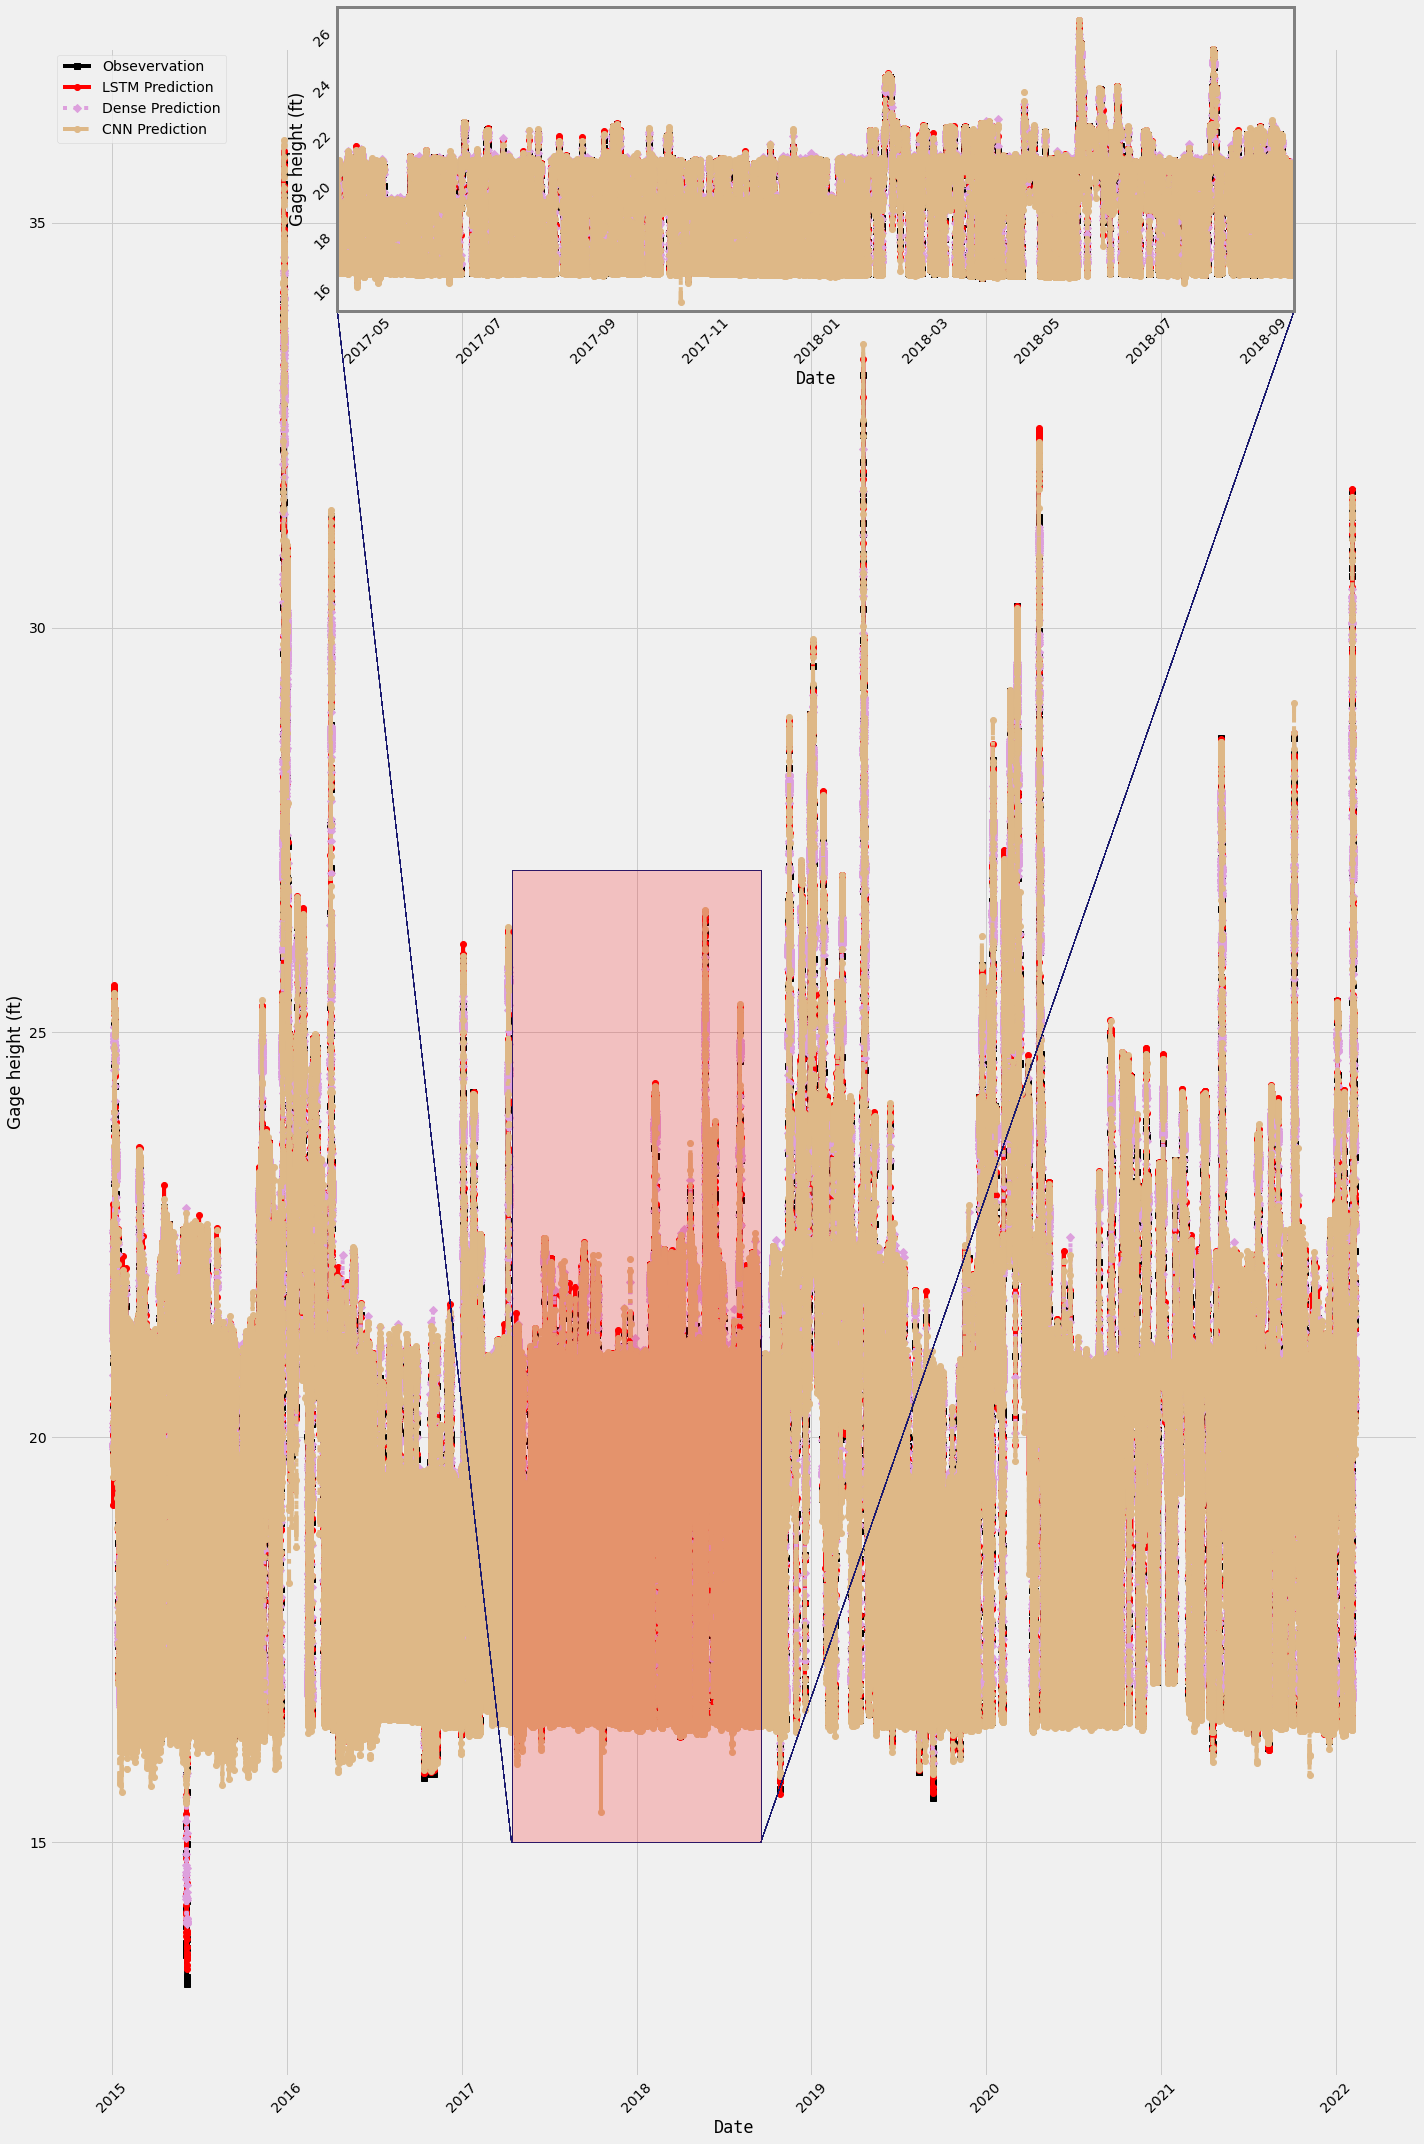

In [35]:
plot_predictions(test_set[:],LSTMprediction[:],CNNprediction[:],Denseprediction[:])

## 48 Hrs

In [53]:
from itertools import chain
#flatten_list = list(chain.from_iterable(Denseprediction.tolist()))
test_set = df['2022-02-07 05':].iloc[:,:]
Test_df = df['2022-02-07 05':].iloc[:,:]

In [54]:
import math
from sklearn.metrics import mean_squared_error
from matplotlib.axes import Axes as ax
import datetime
# Some functions to help out with
from matplotlib.pyplot import figure
def plot_predictions(test,LSTMpredicted, CNN, Dense):
    fig, ax = plt.subplots(figsize=(20,15), tight_layout=True)
    plt.xticks(rotation=45)
    ax.plot(Test_df[:192].index, test[:192],color='black',label='Obsevervation',marker='s')
    ax.plot(Test_df[:192].index, LSTMpredicted,color='red',label='LSTM Prediction',linewidth=4,marker='o')
    ax.plot(Test_df[:192].index, Dense, color='plum',label='Dense Prediction',marker='D', linestyle=":")
    ax.plot(Test_df[:192].index, CNN, color='burlywood',label='CNN Prediction',marker='o',linestyle="-.")
    ax.plot(df[len(df) - len(test_set) - 100:][90:101].index, df[len(df) - len(test_set) - 101:][90:101].values,color='dimgrey',label='Random Data input',marker='s')
    plt.xlabel('Date',{'fontname':'monospace'})
    plt.ylabel('Gage height (ft)')
    plt.legend(loc="lower left",prop={'size': 20})
    
    # inset axes....
    axins = ax.inset_axes([0.6, 0.60, 0.3, 0.39])
    axins.plot(Test_df[:192].index, test[:192],color='black',label='Obsevervation',marker='s')
    axins.plot(Test_df[:192].index, LSTMpredicted,color='red',label='LSTM Prediction',linewidth=4,marker='o')
    axins.plot(Test_df[:192].index, Dense, color='plum',label='Dense Prediction',marker='D', linestyle=":")
    axins.plot(Test_df[:192].index, CNN, color='burlywood',label='CNN Prediction',marker='o',linestyle="-.")
    axins.plot(df[len(df) - len(test_set) - 100:][90:101].index, df[len(df) - len(test_set) - 101:][90:101].values,color='dimgrey',label='Random Data input',marker='s')
    axins.grid(False)
    # sub region of the original image
    x1, x2, y1, y2 = Test_df[:192].index[50],Test_df[:192].index[100], 23.5, 25.3

    axins.set_xlim(x1, x2)
    axins.set_ylim(y1,y2)
    axins.set_xlabel('Date',{'fontname':'monospace'})
    axins.set_ylabel('Gage height (ft)')
    
    axins.tick_params(labelrotation=45)
    # axins.set_xticklabels([])
    # axins.set_yticklabels([])
    for i in range(100):
        ax.indicate_inset_zoom(axins, edgecolor="midnightblue",alpha=1)

    
    ax.indicate_inset_zoom(axins, edgecolor="midnightblue",alpha=0.2,facecolor="red")
    
    axins.spines['bottom'].set_color('0.5')
    axins.spines['top'].set_color('0.5')
    axins.spines['right'].set_color('0.5')
    axins.spines['left'].set_color('0.5')
    
    plt.savefig("48hrs-columbus.png",bbox_inches='tight')
    plt.show()


def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

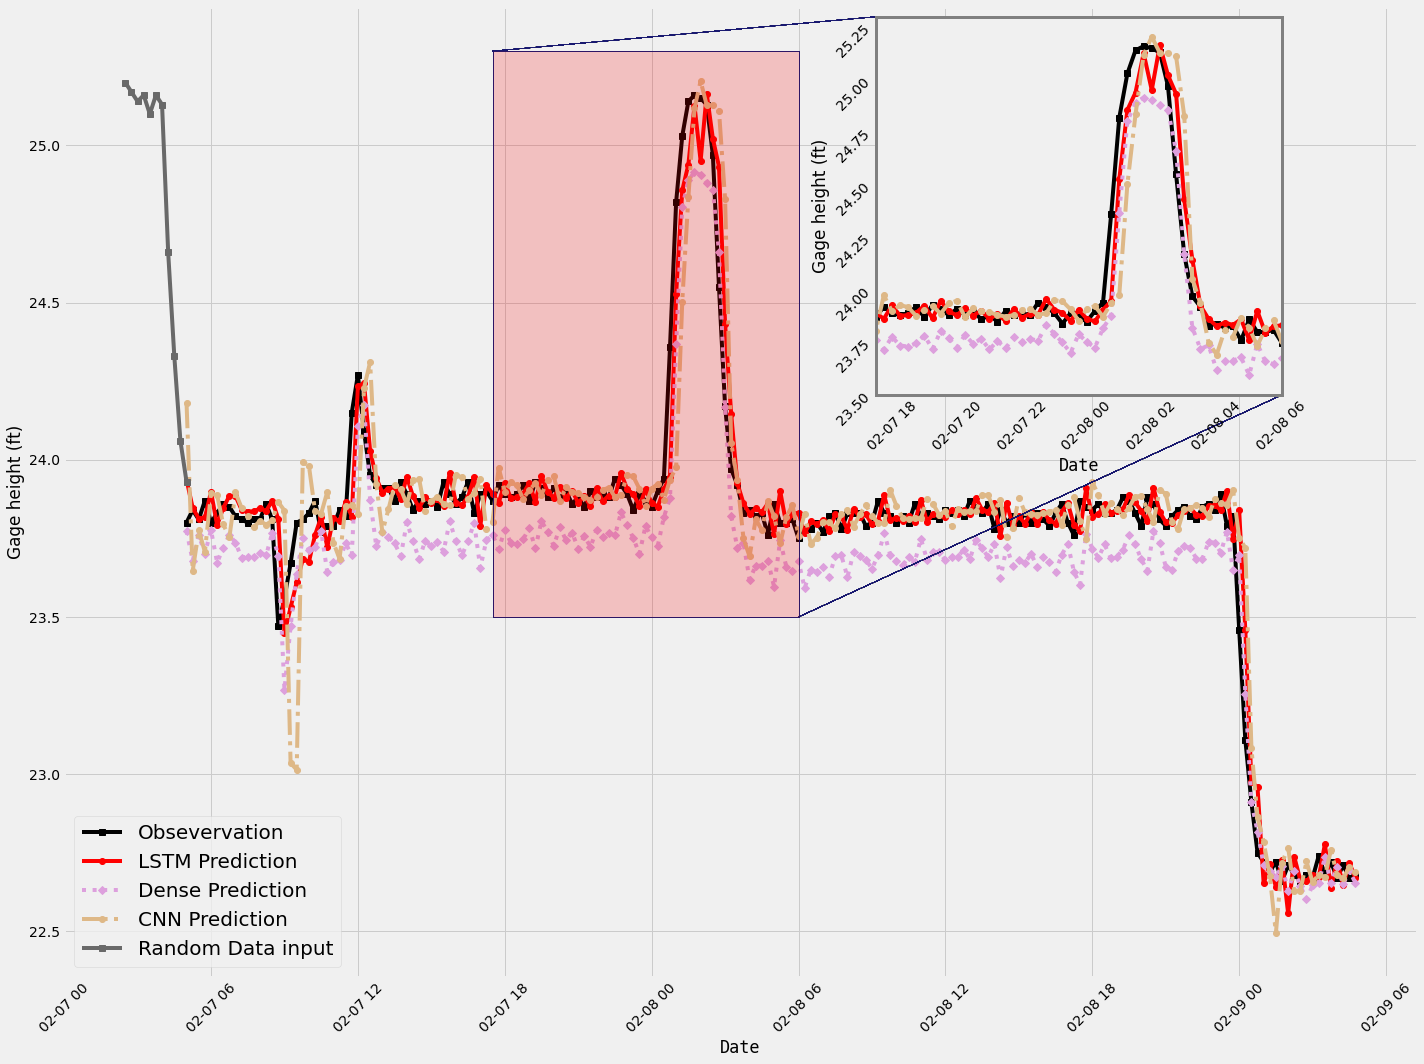

In [55]:
# Visualizing the results for LSTM 
plot_predictions(test_set[:192],LSTMprediction[:192],CNNprediction[:192],Denseprediction[:192])

## 24 Hrs

In [56]:
import math
from sklearn.metrics import mean_squared_error
from matplotlib.axes import Axes as ax
import datetime
# Some functions to help out with
from matplotlib.pyplot import figure
def plot_predictions(test,LSTMpredicted, CNN, Dense):
    fig, ax = plt.subplots(figsize=(20,5), tight_layout=True)
    plt.xticks(rotation=45)
    ax.plot(Test_df[93:189].index, test,color='black',label='Obsevervation',marker='s')
    ax.plot(Test_df[93:189].index, LSTMpredicted,color='red',label='LSTM Prediction',linewidth=4,marker='o')
    ax.plot(Test_df[93:189].index, Dense, color='plum',label='Dense Prediction',marker='D', linestyle=":")
    ax.plot(Test_df[93:189].index, CNN, color='burlywood',label='CNN Prediction',marker='o',linestyle="-.")
    #ax.plot(df[len(df) - len(test_set) - 100:][90:101].index, df[len(df) - len(test_set) - 101:][90:101].values,color='dimgrey',label='Random Data input',marker='s')
    plt.xlabel('Date',{'fontname':'monospace'})
    plt.ylabel('Gage height (ft)')
    plt.legend(loc="lower left")
    
#     # inset axes....
#     axins = ax.inset_axes([0.6, 0.58, 0.3, 0.4])
#     axins.plot(Test_df[93:189].index, test[93:189],color='black',label='Obsevervation',marker='s')
#     axins.plot(Test_df[93:189].index, LSTMpredicted,color='red',label='LSTM Prediction',linewidth=4,marker='o')
#     axins.plot(Test_df[93:189].index, Dense, color='plum',label='Dense Prediction',marker='D', linestyle=":")
#     axins.plot(Test_df[93:189].index, CNN, color='burlywood',label='CNN Prediction',marker='o',linestyle="-.")
#     #axins.plot(df[len(df) - len(test_set) - 100:][90:101].index, df[len(df) - len(test_set) - 101:][90:101].values,color='dimgrey',label='Random Data input',marker='s')
#     axins.grid(False)
#     # sub region of the original image
#     x1, x2, y1, y2 = Test_df[:192].index[50],Test_df[:192].index[100], 23.5, 25.3

#     axins.set_xlim(x1, x2)
#     axins.set_ylim(y1,y2)
#     axins.tick_params(labelrotation=45)
#     # axins.set_xticklabels([])
#     # axins.set_yticklabels([])
#     for i in range(100):
#         ax.indicate_inset_zoom(axins, edgecolor="midnightblue",alpha=1)

    
#     ax.indicate_inset_zoom(axins, edgecolor="midnightblue",alpha=0.2,facecolor="red")
    
#     axins.spines['bottom'].set_color('0.5')
#     axins.spines['top'].set_color('0.5')
#     axins.spines['right'].set_color('0.5')
#     axins.spines['left'].set_color('0.5')
    
#     plt.savefig("Mathplot.png",bbox_inches='tight')
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

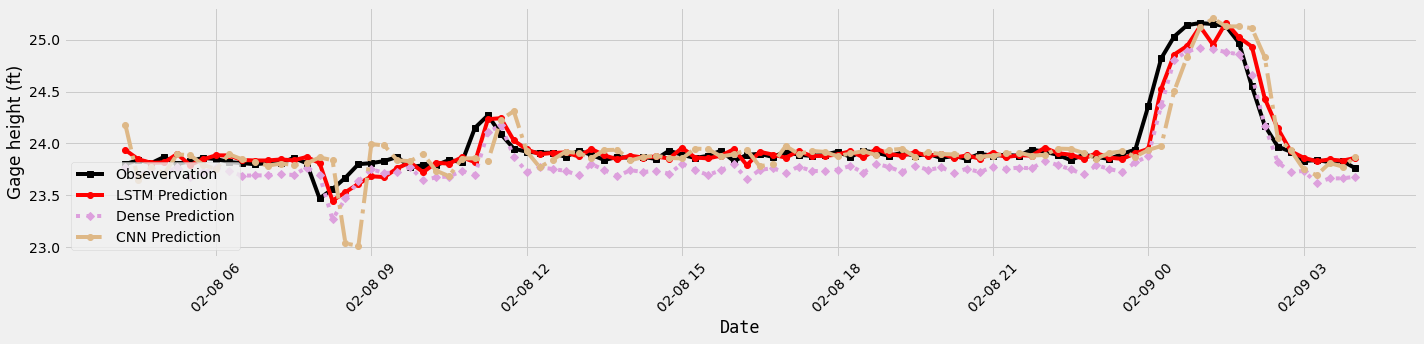

In [57]:
# Visualizing the results for LSTM 
plot_predictions(test_set[0:96],LSTMprediction[0:96],CNNprediction[0:96],Denseprediction[0:96])

## 12 Hrs

In [60]:
import math
from sklearn.metrics import mean_squared_error
from matplotlib.axes import Axes as ax
import datetime
# Some functions to help out with
from matplotlib.pyplot import figure
def plot_predictions(test,LSTMpredicted, CNN, Dense):
    fig, ax = plt.subplots(figsize=(20,5), tight_layout=True)
    plt.xticks(rotation=45)
    ax.plot(Test_df[0:48].index, test,color='black',label='Obsevervation',marker='s')
    ax.plot(Test_df[0:48].index, LSTMpredicted,color='red',label='LSTM Prediction',linewidth=4,marker='o')
    ax.plot(Test_df[0:48].index, Dense, color='plum',label='Dense Prediction',marker='D', linestyle=":")
    ax.plot(Test_df[0:48].index, CNN, color='burlywood',label='CNN Prediction',marker='o',linestyle="-.")
    #ax.plot(df[len(df) - len(test_set) - 100:][90:101].index, df[len(df) - len(test_set) - 101:][90:101].values,color='dimgrey',label='Random Data input',marker='s')
    plt.xlabel('Date',{'fontname':'monospace'})
    plt.ylabel('Gage height (ft)')
    plt.legend(loc="lower left")
    
#     # inset axes....
#     axins = ax.inset_axes([0.6, 0.58, 0.3, 0.4])
#     axins.plot(Test_df[93:189].index, test[93:189],color='black',label='Obsevervation',marker='s')
#     axins.plot(Test_df[93:189].index, LSTMpredicted,color='red',label='LSTM Prediction',linewidth=4,marker='o')
#     axins.plot(Test_df[93:189].index, Dense, color='plum',label='Dense Prediction',marker='D', linestyle=":")
#     axins.plot(Test_df[93:189].index, CNN, color='burlywood',label='CNN Prediction',marker='o',linestyle="-.")
#     #axins.plot(df[len(df) - len(test_set) - 100:][90:101].index, df[len(df) - len(test_set) - 101:][90:101].values,color='dimgrey',label='Random Data input',marker='s')
#     axins.grid(False)
#     # sub region of the original image
#     x1, x2, y1, y2 = Test_df[:192].index[50],Test_df[:192].index[100], 23.5, 25.3

#     axins.set_xlim(x1, x2)
#     axins.set_ylim(y1,y2)
#     axins.tick_params(labelrotation=45)
#     # axins.set_xticklabels([])
#     # axins.set_yticklabels([])
#     for i in range(100):
#         ax.indicate_inset_zoom(axins, edgecolor="midnightblue",alpha=1)

    
#     ax.indicate_inset_zoom(axins, edgecolor="midnightblue",alpha=0.2,facecolor="red")
    
#     axins.spines['bottom'].set_color('0.5')
#     axins.spines['top'].set_color('0.5')
#     axins.spines['right'].set_color('0.5')
#     axins.spines['left'].set_color('0.5')
    
#     plt.savefig("Mathplot.png",bbox_inches='tight')
    plt.show()
    
    #Performance(test,Dense, CNN, LSTMpredicted)

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

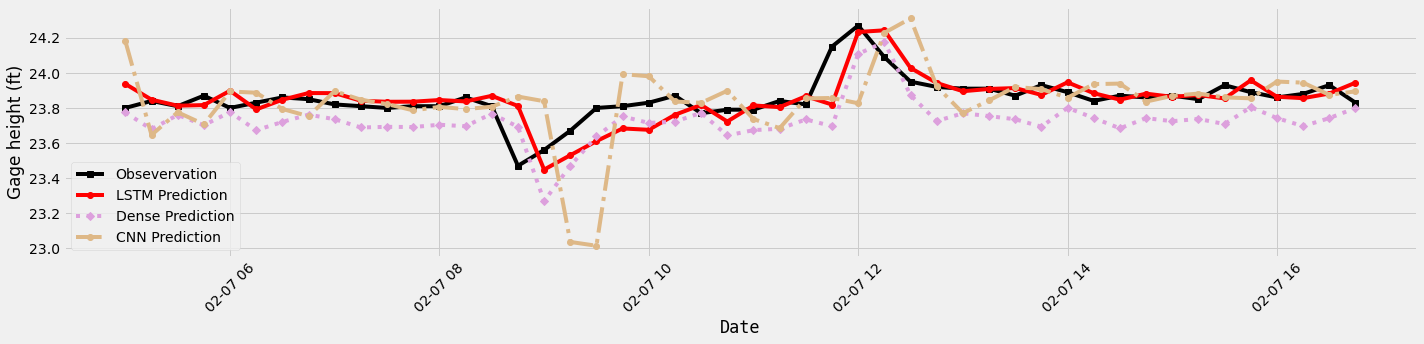

In [61]:
plot_predictions(test_set[0:48],LSTMprediction[0:48],CNNprediction[0:48],Denseprediction[0:48])

# 6Hrs

In [62]:
import math
from sklearn.metrics import mean_squared_error
from matplotlib.axes import Axes as ax
import datetime
# Some functions to help out with
from matplotlib.pyplot import figure
def plot_predictions(test,LSTMpredicted, CNN, Dense):
    fig, ax = plt.subplots(figsize=(15,5), tight_layout=True)
    plt.xticks(rotation=45)
    ax.plot(Test_df[0:24].index, test,color='black',label='Obsevervation',marker='s')
    ax.plot(Test_df[0:24].index, LSTMpredicted,color='red',label='LSTM Prediction',linewidth=4,marker='o')
    ax.plot(Test_df[0:24].index, Dense, color='plum',label='Dense Prediction',marker='D', linestyle=":")
    ax.plot(Test_df[0:24].index, CNN, color='burlywood',label='CNN Prediction',marker='o',linestyle="-.")
    #ax.plot(df[len(df) - len(test_set) - 100:][90:101].index, df[len(df) - len(test_set) - 101:][90:101].values,color='dimgrey',label='Random Data input',marker='s')
    plt.xlabel('Date',{'fontname':'monospace'})
    plt.ylabel('Gage height (ft)')
    plt.legend(loc="lower left")
    
#     # inset axes....
#     axins = ax.inset_axes([0.6, 0.58, 0.3, 0.4])
#     axins.plot(Test_df[93:189].index, test[93:189],color='black',label='Obsevervation',marker='s')
#     axins.plot(Test_df[93:189].index, LSTMpredicted,color='red',label='LSTM Prediction',linewidth=4,marker='o')
#     axins.plot(Test_df[93:189].index, Dense, color='plum',label='Dense Prediction',marker='D', linestyle=":")
#     axins.plot(Test_df[93:189].index, CNN, color='burlywood',label='CNN Prediction',marker='o',linestyle="-.")
#     #axins.plot(df[len(df) - len(test_set) - 100:][90:101].index, df[len(df) - len(test_set) - 101:][90:101].values,color='dimgrey',label='Random Data input',marker='s')
#     axins.grid(False)
#     # sub region of the original image
#     x1, x2, y1, y2 = Test_df[:192].index[50],Test_df[:192].index[100], 23.5, 25.3

#     axins.set_xlim(x1, x2)
#     axins.set_ylim(y1,y2)
#     axins.tick_params(labelrotation=45)
#     # axins.set_xticklabels([])
#     # axins.set_yticklabels([])
#     for i in range(100):
#         ax.indicate_inset_zoom(axins, edgecolor="midnightblue",alpha=1)

    
#     ax.indicate_inset_zoom(axins, edgecolor="midnightblue",alpha=0.2,facecolor="red")
    
#     axins.spines['bottom'].set_color('0.5')
#     axins.spines['top'].set_color('0.5')
#     axins.spines['right'].set_color('0.5')
#     axins.spines['left'].set_color('0.5')
    
#     plt.savefig("Mathplot.png",bbox_inches='tight')
    #plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

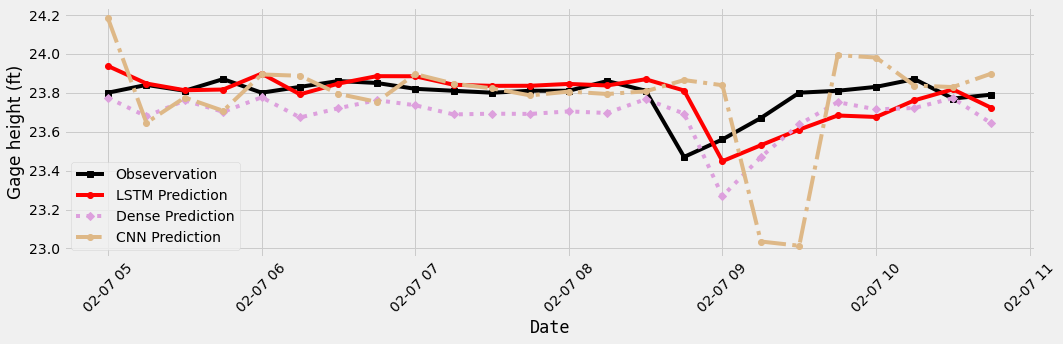

In [63]:
plot_predictions(test_set[0:24],LSTMprediction[0:24],CNNprediction[0:24],Denseprediction[0:24])